todo: move to lasagne recipes fork, and import the cifar10 data loader, and run exps on cuda4

In [2]:
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.regularization import *
from lasagne.random import get_rng
from lasagne.updates import *
from lasagne.init import *
import numpy as np
import sys
sys.setrecursionlimit(10000)
sys.path.append("../../modules/")
import helper as hp

from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

import matplotlib.pyplot as plt
%matplotlib inline

import os
import cPickle as pickle

from theano.tensor import TensorType

from theano.ifelse import ifelse

from time import time

%load_ext rpy2.ipython

from scipy import stats

import deep_residual_learning_CIFAR10

import math

//anaconda/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


We keep all the contents of the tensor with survival probability $p$, so the expectation at test time is also $p$.

In [57]:
class BinomialDropLayer(Layer):
    def __init__(self, incoming, p=0.5, **kwargs):
        super(BinomialDropLayer, self).__init__(incoming, **kwargs)
        self._srng = RandomStreams(get_rng().randint(1, 2147462579))
        self.p = p

    def get_output_for(self, input, deterministic=False, **kwargs):
        if deterministic:
            return self.p*input
        else:
            #mask = self._srng.binomial(n=1, p=(self.p), size=(input.shape[0],),
            #    dtype=input.dtype)
            # apply the same thing to all examples in the minibatch
            mask = T.zeros((input.shape[0],)) + self._srng.binomial((1,), p=self.p, dtype=input.dtype)[0]
            mask = mask.dimshuffle(0,'x','x','x')
            return mask*input

In [58]:
class IfElseDropLayer(Layer):
    def __init__(self, incoming, p=0.5, **kwargs):
        super(IfElseDropLayer, self).__init__(incoming, **kwargs)
        self._srng = RandomStreams(get_rng().randint(1, 2147462579))
        self.p = p

    def get_output_for(self, input, deterministic=False, **kwargs):
        if deterministic:
            return self.p*input
        else:
            return ifelse(
                T.lt(self._srng.uniform( (1,), 0, 1)[0], self.p),
                input,
                T.zeros(input.shape)
            )

In [59]:
class SkippableNonlinearityLayer(Layer):
    def __init__(self, incoming, nonlinearity=rectify, p=0.5, **kwargs):
        super(SkippableNonlinearityLayer, self).__init__(incoming, **kwargs)
        self.nonlinearity = (identity if nonlinearity is None
                             else nonlinearity)
        self._srng = RandomStreams(get_rng().randint(1, 2147462579))
        self.p = p
    def get_output_for(self, input, deterministic=False, **kwargs):
        if deterministic or self.p == 0.0:
            # apply the bernoulli expectation
            return self.p*input + (1-self.p)*self.nonlinearity(input)
        else:
            if input.ndim==4:
                mask = self._srng.binomial(n=1, p=(self.p), size=(input.shape[0],1,1,1),
                    dtype=input.dtype)
                mask = T.addbroadcast(mask, 1,2,3)
                return mask*input + (1-mask)*self.nonlinearity(input)
            elif input.ndim == 2:
                mask = self._srng.binomial(n=1, p=(self.p), size=(input.shape[0],1),
                    dtype=input.dtype)
                mask = T.addbroadcast(mask, 1)
                return mask*input + (1-mask)*self.nonlinearity(input) 

In [60]:
class MoreSkippableNonlinearityLayer(Layer):
    def __init__(self, incoming, nonlinearity=rectify, p=0.5,
                 **kwargs):
        super(MoreSkippableNonlinearityLayer, self).__init__(incoming, **kwargs)
        self.nonlinearity = (identity if nonlinearity is None
                             else nonlinearity)
        self._srng = RandomStreams(get_rng().randint(1, 2147462579))
        self.p = p

    def get_output_for(self, input, deterministic=False, **kwargs):
        if deterministic or self.p == 0.0:
            # apply the bernoulli expectation
            return self.p*input + (1-self.p)*self.nonlinearity(input)
        else:
            mask = self._srng.binomial(n=1, p=(self.p), size=input.shape,
                dtype=input.dtype)
            return mask*input + (1-mask)*self.nonlinearity(input) 

There is a difference between this residual block method and the one that is defined in [link]. When the number of filters is different to the layer's output shape (or the stride is different), instead of using a convolution to make things compatible, we use an average pooling with a pool size of 1 and a the defined stride, followed by (if necessary) adding extra zero-padded feature maps. This is because this is how the authors in [link] have defined it.

In [61]:
def residual_block(layer, n_out_channels, stride=1, survival_p=0.5, nonlinearity_p=0.0):
    conv = layer
    if stride > 1:
        layer = Pool2DLayer(layer, pool_size=1, stride=stride, mode="average_inc_pad")
    if (n_out_channels != layer.output_shape[1]):
        diff = n_out_channels-layer.output_shape[1]
        if diff % 2 == 0: 
            width_tp = ((diff/2, diff/2),)
        else:
            width_tp = (((diff/2)+1, diff/2),)
        layer = pad(layer, batch_ndim=1, width=width_tp)
    conv = Conv2DLayer(conv, num_filters=n_out_channels,
                       filter_size=(3,3), stride=(stride,stride), pad=(1,1), nonlinearity=linear)
    conv = BatchNormLayer(conv)
    if nonlinearity_p == 0.0:
        conv = NonlinearityLayer(conv, nonlinearity=rectify)
    else:
        conv = MoreSkippableNonlinearityLayer(conv, p=nonlinearity_p, nonlinearity=rectify)
    conv = Conv2DLayer(conv, num_filters=n_out_channels,
                       filter_size=(3,3), stride=(1,1), pad=(1,1), nonlinearity=linear)
    conv = BatchNormLayer(conv)
    conv = BinomialDropLayer(conv, p=survival_p)
    if nonlinearity_p == 0.0:
        return NonlinearityLayer(ElemwiseSumLayer([conv, layer]), nonlinearity=rectify)
    else:
        return MoreSkippableNonlinearityLayer(ElemwiseSumLayer([conv, layer]), nonlinearity=rectify)

In [62]:
def yu_cifar10_net(args):
    # Architecture from:
    # https://github.com/yueatsprograms/Stochastic_Depth/blob/master/main.lua
    N = 18
    survival_p = args["survival_p"]
    nonlinearity_p = args["nonlinearity_p"]
    layer = InputLayer( (None, 3, 32, 32) )
    layer = Conv2DLayer(layer, num_filters=16, filter_size=3, stride=1, pad='same')
    #layer = Pool2DLayer(layer, 2)
    for _ in range(N):
        layer = residual_block(layer, 16, survival_p=survival_p, nonlinearity_p=args["nonlinearity_p"])
    layer = residual_block(layer, 32, stride=2, survival_p=survival_p, nonlinearity_p=args["nonlinearity_p"])
    for _ in range(N):
        layer = residual_block(layer, 32, survival_p=survival_p, nonlinearity_p=args["nonlinearity_p"])
    layer = residual_block(layer, 64, stride=2, survival_p=survival_p, nonlinearity_p=args["nonlinearity_p"])
    for _ in range(N):
        layer = residual_block(layer, 64, survival_p=survival_p, nonlinearity_p=args["nonlinearity_p"])
    layer = Pool2DLayer(layer, pool_size=8, stride=1, mode="average_inc_pad")
    layer = DenseLayer(layer, num_units=10, nonlinearity=softmax)
    for layer in get_all_layers(layer):
        print layer, layer.output_shape
    print "number of params:", count_params(layer)
    return layer

----

In [65]:
data = deep_residual_learning_CIFAR10.load_data()
if "QUICK" in os.environ:
    sys.stderr.write("loading smaller version of cifar10...\n")
    X_train_and_valid, y_train_and_valid, X_test, y_test = \
        data["X_train"][0:500], data["Y_train"][0:500], data["X_test"][0:500], data["Y_test"][0:500]
else:   
    X_train_and_valid, y_train_and_valid, X_test, y_test = \
        data["X_train"][0:50000], data["Y_train"][0:50000], data["X_test"], data["Y_test"]

loading smaller version of cifar10...


In [66]:
X_train = X_train_and_valid[ 0 : 0.9*X_train_and_valid.shape[0] ]
y_train = y_train_and_valid[ 0 : 0.9*y_train_and_valid.shape[0] ]
X_valid = X_train_and_valid[ 0.9*X_train_and_valid.shape[0] :: ]
y_valid = y_train_and_valid[ 0.9*y_train_and_valid.shape[0] :: ]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [67]:
X_train = theano.shared(np.asarray(X_train, dtype=theano.config.floatX), borrow=True)
y_train = theano.shared(np.asarray(y_train, dtype=theano.config.floatX), borrow=True)
X_valid = theano.shared(np.asarray(X_valid, dtype=theano.config.floatX), borrow=True)
y_valid = theano.shared(np.asarray(y_valid, dtype=theano.config.floatX), borrow=True)
X_test = theano.shared(np.asarray(X_test, dtype=theano.config.floatX), borrow=True)
y_test = theano.shared(np.asarray(y_test, dtype=theano.config.floatX), borrow=True)

-----

In [68]:
def get_net(l_out, data, args={}):
    # ----
    X = T.tensor4('X')
    y = T.ivector('y')
    idx = T.lscalar('idx')
    # ----
    net_out = get_output(l_out, X)
    net_out_det = get_output(l_out, X, deterministic=True)
    loss = categorical_crossentropy(net_out, y).mean()
    loss_det = categorical_crossentropy(net_out_det, y).mean()
    if "l2" in args:
        loss += args["l2"]*regularize_layer_params(l_out, l2)
        loss_det += args["l2"]*regularize_layer_params(l_out, l2)
    params = get_all_params(l_out, trainable=True)
    if "max_norm" in args:
        grads = total_norm_constraint( T.grad(loss, params), max_norm=args["max_norm"])
    else:
        grads = T.grad(loss, params)
    learning_rate = 0.01 if "learning_rate" not in args else args["learning_rate"]
    momentum = 0.9 if "momentum" not in args else args["momentum"]
    if "rmsprop" in args:
        sys.stderr.write("using rmsprop instead of nesterov momentum...\n")
        updates = rmsprop(grads, params, learning_rate=learning_rate)
    else:
        updates = nesterov_momentum(grads, params, learning_rate=learning_rate, momentum=momentum)
    # index fns
    bs = args["batch_size"]
    X_train, y_train, X_valid, y_valid = data
    y_train = T.cast(y_train, "int32")
    y_valid = T.cast(y_valid, "int32")
    train_fn = theano.function(inputs=[idx], outputs=loss, updates=updates, 
        givens={X: X_train[idx*bs : (idx+1)*bs], y: y_train[idx*bs : (idx+1)*bs]}
    )
    
    # this is for the validation set
    # make the output deterministic
    loss_fn = theano.function(inputs=[], outputs=loss_det, givens={X: X_valid,y: y_valid})
    acc = T.mean( T.eq( T.argmax(net_out_det,axis=1), y_valid) )
    acc_fn = theano.function(inputs=[], outputs=acc, givens={X:X_valid})
    # this is meant to be non-deterministic
    preds = T.argmax(net_out,axis=1)
    preds_fn = theano.function(inputs=[], outputs=preds, givens={X:X_valid})
    # this is also meant to be non-deterministic
    out_fn = theano.function(inputs=[], outputs=net_out, givens={X:X_valid})
    outs_with_nonlinearity = theano.function(
        [X], [ get_output(layer, X, deterministic=True) for layer in get_all_layers(l_out) 
              if isinstance(layer, SkippableNonlinearityLayer) or \
                  isinstance(layer, MoreSkippableNonlinearityLayer) ], on_unused_input="warn"
    )
    outs_without_nonlinearity = theano.function(
        [X], [ get_output(layer, X, deterministic=True) for layer in get_all_layers(l_out) 
              if isinstance(layer, Conv2DLayer) or isinstance(layer, DenseLayer) ]
    )
    return {
        "train_fn": train_fn,
        "acc_fn": acc_fn,
        "preds_fn": preds_fn,
        "loss_fn": loss_fn,
        "out_fn": out_fn,
        "outs_with_nonlinearity": outs_with_nonlinearity,
        "outs_without_nonlinearity": outs_without_nonlinearity,
        "l_out": l_out,
        "n_batches": X_train.get_value().shape[0] // bs
    }

In [69]:
def train(net_cfg, 
          num_epochs,
          data,
          out_file=None,
          print_out=True,
          debug=False,
          resume=False):
    # prepare the out_file
    f = None
    if resume == False:
        if out_file != None:
            f = open("%s.txt" % out_file, "wb")
            f.write("epoch,train_loss,valid_loss,valid_accuracy,valid_accuracy_ensemble,time\n")
        if print_out:
            print "epoch,train_loss,valid_loss,valid_accuracy,valid_accuracy_ensemble,time"
    else:
        sys.stderr.write("resuming training...\n")
        if out_file != None:
            f = open("%s.txt" % out_file, "ab")
        l_out = net_cfg["l_out"]
        with open("%s.model" % out_file) as g:
            set_all_param_values(l_out, pickle.load(g))          
    # extract functions
    X_train, y_train, X_valid, y_valid = data
    train_fn = net_cfg["train_fn"]
    loss_fn = net_cfg["loss_fn"]
    acc_fn = net_cfg["acc_fn"]
    preds_fn = net_cfg["preds_fn"]
    outs_with_nonlinearity = net_cfg["outs_with_nonlinearity"]
    # training
    n_batches = net_cfg["n_batches"]
    idxs = [x for x in range(0, n_batches)]
    if debug:
        sys.stderr.write("n_batches: %s\n" % n_batches)
        sys.stderr.write("idxs: %s\n" % idxs)
    for epoch in range(0, num_epochs):
        this_train_losses = []
        np.random.shuffle(idxs)
        #if debug:
        #    sys.stderr.write("%s\n" % idxs)
        t0 = time()
        for i in range(0, len(idxs)):
            loss_for_this_batch = train_fn( idxs[i] )
            this_train_losses.append( loss_for_this_batch )
        time_taken = time() - t0
        valid_loss = loss_fn()
        valid_acc = acc_fn()
        ## EXPERIMENTAL ##
        mat = []
        numiters=10
        for i in range(0, numiters):
            mat.append( preds_fn() )
        mat = stats.mode(np.vstack(mat))[0]
        valid_acc_ensemble = np.mean(mat==y_valid.get_value())
        ## ------------ ##
        if f != None:
            f.write(
                "%i,%f,%f,%f,%f,%f\n" %
                    (epoch+1, np.mean(this_train_losses), valid_loss, valid_acc, valid_acc_ensemble, time_taken) 
            )
        if print_out:
            print "%i,%f,%f,%f,%f,%f" % \
                (epoch+1, np.mean(this_train_losses), valid_loss, valid_acc, valid_acc_ensemble, time_taken)
        #print valid_loss
        #return train_losses
    if f != None:
        f.close()
        # ok, now save the model as a pkl
        l_out = net_cfg["l_out"]
        with open("%s.model" % out_file, "wb") as g:
            pickle.dump(get_all_param_values(l_out), g, pickle.HIGHEST_PROTOCOL)

----

Reproduce stochastic depth paper using varying values of $p$ (ie no linear decay).

In [22]:
if "CIFAR10_EXP_1" in os.environ:
    out_folder = "output_stochastic_depth_resnet"
    for replicate in [0,1,2]:
        for p in [0.1, 0.2, 0.3, 0.4, 0.5]:
            np.random.seed(replicate)
            this_args = {}
            out_file = "%s/p%f_stochastic_depth.%i" % (out_folder, p, replicate)
            if os.path.isfile("%s.txt" % out_file):
                continue
            train(
                get_net(
                    yu_cifar10_net({"survival_p": p, "nonlinearity_p": 0.0}),
                    (X_train, y_train, X_valid, y_valid), 
                    {"batch_size": 128}
                ),
                num_epochs=20,
                data=(X_train, y_train, X_valid, y_valid),
                out_file=out_file,
                debug=False
            )

<lasagne.layers.input.InputLayer object at 0x10f094690> (None, 3, 32, 32)
<lasagne.layers.conv.Conv2DLayer object at 0x10f153cd0> (None, 16, 32, 32)
<lasagne.layers.conv.Conv2DLayer object at 0x10f154c50> (None, 16, 32, 32)
<lasagne.layers.conv.Conv2DLayer object at 0x10f154bd0> (None, 16, 32, 32)
<__main__.IfElseDropLayer object at 0x10f154c10> (None, 16, 32, 32)
<lasagne.layers.merge.ElemwiseSumLayer object at 0x10f1620d0> (None, 16, 32, 32)
<lasagne.layers.special.NonlinearityLayer object at 0x10f162110> (None, 16, 32, 32)
<lasagne.layers.conv.Conv2DLayer object at 0x10f162150> (None, 16, 32, 32)
<lasagne.layers.conv.Conv2DLayer object at 0x10f162190> (None, 16, 32, 32)
<__main__.IfElseDropLayer object at 0x10f162090> (None, 16, 32, 32)
<lasagne.layers.merge.ElemwiseSumLayer object at 0x10f1625d0> (None, 16, 32, 32)
<lasagne.layers.special.NonlinearityLayer object at 0x10f162610> (None, 16, 32, 32)
<lasagne.layers.conv.Conv2DLayer object at 0x10f162650> (None, 16, 32, 32)
<lasagne.l

RuntimeError: maximum recursion depth exceeded while calling a Python object

Do stochastic nonlinearities.

In [ ]:
if "CIFAR10_EXP_2" in os.environ:
    out_folder = "output_stochastic_depth_resnet"
    for replicate in [0,1,2]:
        for p in [0.1, 0.2, 0.3, 0.4, 0.5]:
            np.random.seed(replicate)
            this_args = {}
            out_file = "%s/p%f_stochastic_nonlinearity.%i" % (out_folder, p, replicate)
            if os.path.isfile("%s.txt" % out_file):
                continue
            train(
                get_net(
                    yu_cifar10_net({"survival_p": 1.0, "nonlinearity_p": p}),
                    (X_train, y_train, X_valid, y_valid), 
                    {"batch_size": 128}
                ),
                num_epochs=20,
                data=(X_train, y_train, X_valid, y_valid),
                out_file=out_file,
                debug=False
            )

-----

## Plot the curves for stochastic depth

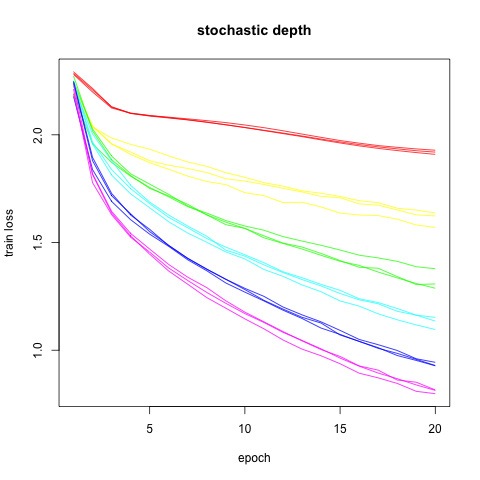

In [38]:
%%R -w 480 -h 480
ps = c(
    "p0.000000",
    "p0.100000",
    "p0.200000",
    "p0.300000",
    "p0.400000",
    "p0.500000"
)

#par(mfrow=c(2,2))

rainbows = rainbow(length(ps))
# train loss
max_y = 0
min_y = 10000
for(i in 1:length(ps)) {
    for(seed in 0:2) {
        df = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_depth.",seed,".txt",sep=""))
        if(min(df$train_loss) < min_y) {
            min_y = min(df$train_loss)
        }
        if(max(df$train_loss) > max_y) {
            max_y = max(df$train_loss)
        }
    }
}

for(i in 1:length(ps)) {
    df = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_depth.",0,".txt",sep=""))
    df2 = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_depth.",1,".txt",sep=""))
    df3 = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_depth.",2,".txt",sep=""))

    if(i==1) {
        plot(df$train_loss, type="l", ylim=c(min_y, max_y), 
             col=rainbows[i], xlab="epoch", ylab="train loss", 
             main="stochastic depth")
        lines(df2$train_loss, col=rainbows[i])
        lines(df3$train_loss, col=rainbows[i])
    } else {
        lines(df$train_loss, col=rainbows[i])
        lines(df2$train_loss, col=rainbows[i])
        lines(df3$train_loss, col=rainbows[i])
    }
}


Plot the validation curves (non-averaging)

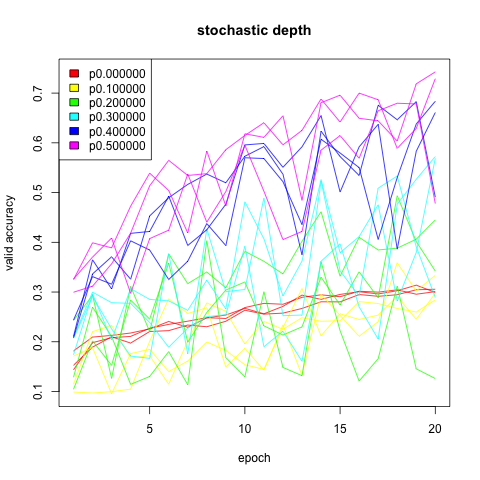

In [46]:
%%R -w 480 -h 480
ps = c(
    "p0.000000",
    "p0.100000",
    "p0.200000",
    "p0.300000",
    "p0.400000",
    "p0.500000"
)

#par(mfrow=c(2,2))

rainbows = rainbow(length(ps))
# train loss
max_y = -10000
min_y = 10000
for(i in 1:length(ps)) {
    for(seed in 0:2) {
        df = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_depth.",seed,".txt",sep=""))
        if(min(df$valid_accuracy) < min_y) {
            min_y = min(df$valid_accuracy)
        }
        if(max(df$valid_accuracy) > max_y) {
            max_y = max(df$valid_accuracy)
        }
    }
}

for(i in 1:length(ps)) {
    df = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_depth.",0,".txt",sep=""))
    df2 = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_depth.",1,".txt",sep=""))
    df3 = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_depth.",2,".txt",sep=""))
    if(i==1) {
        plot(df$valid_accuracy, type="l", ylim=c(min_y, max_y), 
             col=rainbows[i], xlab="epoch", ylab="valid accuracy", 
             main="stochastic depth")
        lines(df2$valid_accuracy, col=rainbows[i])
        lines(df3$valid_accuracy, col=rainbows[i])
    } else {
        lines(df$valid_accuracy, col=rainbows[i])
        lines(df2$valid_accuracy, col=rainbows[i])
        lines(df3$valid_accuracy, col=rainbows[i])
    }
}
legend("topleft", fill=rainbows, legend=ps)




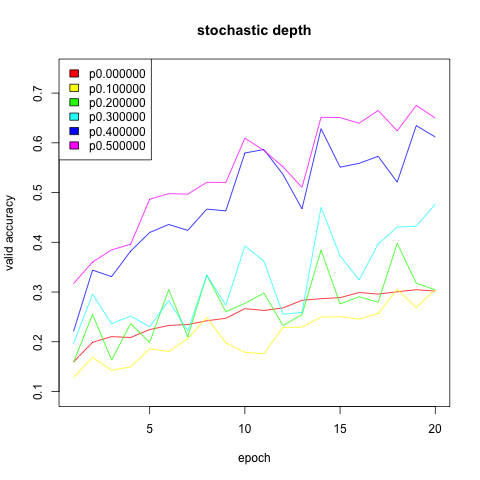

In [47]:
%%R -w 480 -h 480
ps = c(
    "p0.000000",
    "p0.100000",
    "p0.200000",
    "p0.300000",
    "p0.400000",
    "p0.500000"
)

#par(mfrow=c(2,2))

rainbows = rainbow(length(ps))
# train loss
max_y = -10000
min_y = 10000
for(i in 1:length(ps)) {
    for(seed in 0:2) {
        df = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_depth.",seed,".txt",sep=""))
        if(min(df$valid_accuracy) < min_y) {
            min_y = min(df$valid_accuracy)
        }
        if(max(df$valid_accuracy) > max_y) {
            max_y = max(df$valid_accuracy)
        }
    }
}

for(i in 1:length(ps)) {
    df = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_depth.",0,".txt",sep=""))
    df2 = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_depth.",1,".txt",sep=""))
    df3 = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_depth.",2,".txt",sep=""))
    dff = (df+df2+df3) / 3
    if(i==1) {
        plot(dff$valid_accuracy, type="l", ylim=c(min_y, max_y), 
             col=rainbows[i], xlab="epoch", ylab="valid accuracy", 
             main="stochastic depth")
    } else {
        lines(dff$valid_accuracy, col=rainbows[i])
    }
}
legend("topleft", fill=rainbows, legend=ps)




## Plot the curves for stochastic nonlinearity

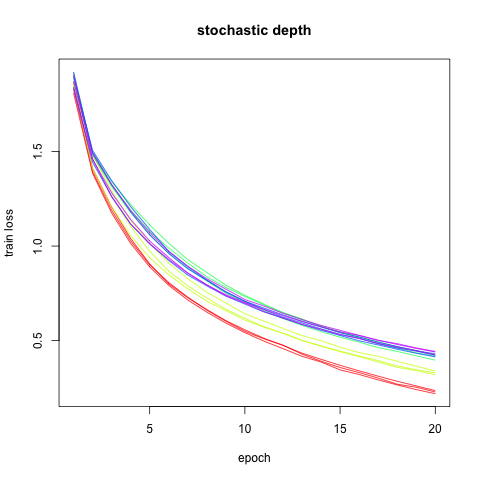

In [52]:
%%R -w 480 -h 480
ps = c(
    "p0.100000",
    "p0.200000",
    "p0.300000",
    "p0.400000",
    "p0.500000"
)

#par(mfrow=c(2,2))

rainbows = rainbow(length(ps))
# train loss
max_y = -10000
min_y = 10000
for(i in 1:length(ps)) {
    for(seed in 0:2) {
        #print(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_nonlinearity.",0,".txt",sep=""))
        df = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_nonlinearity.",seed,".txt",sep=""))
        if(min(df$train_loss) < min_y) {
            min_y = min(df$train_loss)
        }
        if(max(df$train_loss) > max_y) {
            max_y = max(df$train_loss)
        }
    }
}

for(i in 1:length(ps)) {
    df = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_nonlinearity.",0,".txt",sep=""))
    df2 = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_nonlinearity.",1,".txt",sep=""))
    df3 = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_nonlinearity.",2,".txt",sep=""))

    if(i==1) {
        plot(df$train_loss, type="l", ylim=c(min_y, max_y), 
             col=rainbows[i], xlab="epoch", ylab="train loss", 
             main="stochastic depth")
        lines(df2$train_loss, col=rainbows[i])
        lines(df3$train_loss, col=rainbows[i])
    } else {
        lines(df$train_loss, col=rainbows[i])
        lines(df2$train_loss, col=rainbows[i])
        lines(df3$train_loss, col=rainbows[i])
    }
}


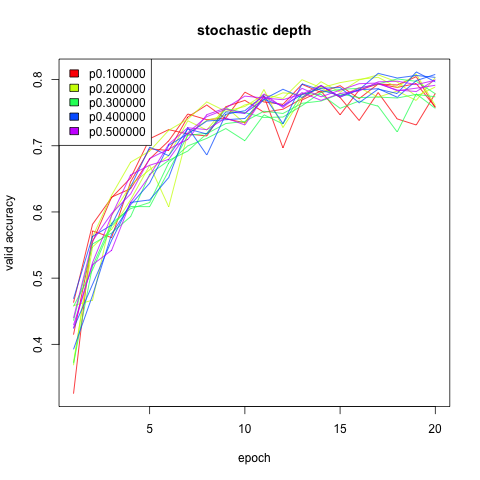

In [53]:
%%R -w 480 -h 480
ps = c(
    "p0.100000",
    "p0.200000",
    "p0.300000",
    "p0.400000",
    "p0.500000"
)

#par(mfrow=c(2,2))

rainbows = rainbow(length(ps))
# train loss
max_y = -10000
min_y = 10000
for(i in 1:length(ps)) {
    for(seed in 0:2) {
        df = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_nonlinearity.",seed,".txt",sep=""))
        if(min(df$valid_accuracy) < min_y) {
            min_y = min(df$valid_accuracy)
        }
        if(max(df$valid_accuracy) > max_y) {
            max_y = max(df$valid_accuracy)
        }
    }
}

for(i in 1:length(ps)) {
    df = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_nonlinearity.",0,".txt",sep=""))
    df2 = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_nonlinearity.",1,".txt",sep=""))
    df3 = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_nonlinearity.",2,".txt",sep=""))
    if(i==1) {
        plot(df$valid_accuracy, type="l", ylim=c(min_y, max_y), 
             col=rainbows[i], xlab="epoch", ylab="valid accuracy", 
             main="stochastic depth")
        lines(df2$valid_accuracy, col=rainbows[i])
        lines(df3$valid_accuracy, col=rainbows[i])
    } else {
        lines(df$valid_accuracy, col=rainbows[i])
        lines(df2$valid_accuracy, col=rainbows[i])
        lines(df3$valid_accuracy, col=rainbows[i])
    }
}
legend("topleft", fill=rainbows, legend=ps)




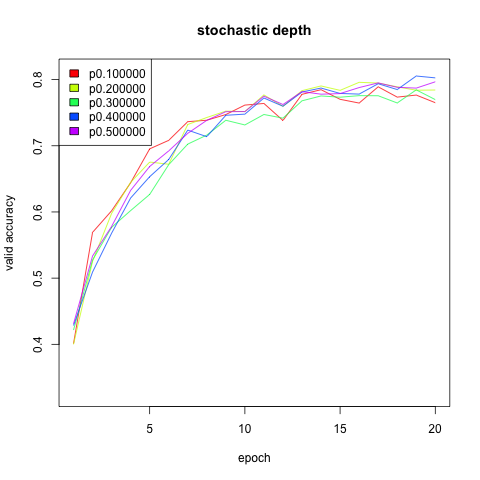

In [54]:
%%R -w 480 -h 480
ps = c(
    "p0.100000",
    "p0.200000",
    "p0.300000",
    "p0.400000",
    "p0.500000"
)

#par(mfrow=c(2,2))

rainbows = rainbow(length(ps))
# train loss
max_y = -10000
min_y = 10000
for(i in 1:length(ps)) {
    for(seed in 0:2) {
        df = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_nonlinearity.",seed,".txt",sep=""))
        if(min(df$valid_accuracy) < min_y) {
            min_y = min(df$valid_accuracy)
        }
        if(max(df$valid_accuracy) > max_y) {
            max_y = max(df$valid_accuracy)
        }
    }
}

for(i in 1:length(ps)) {
    df = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_nonlinearity.",0,".txt",sep=""))
    df2 = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_nonlinearity.",1,".txt",sep=""))
    df3 = read.csv(paste("output_stochastic_depth_resnet/",ps[i],"_stochastic_nonlinearity.",2,".txt",sep=""))
    dff = (df+df2+df3) / 3
    if(i==1) {
        plot(dff$valid_accuracy, type="l", ylim=c(min_y, max_y), 
             col=rainbows[i], xlab="epoch", ylab="valid accuracy", 
             main="stochastic depth")
    } else {
        lines(dff$valid_accuracy, col=rainbows[i])
    }
}
legend("topleft", fill=rainbows, legend=ps)




In [75]:
import draw_net
reload(draw_net)

<module 'draw_net' from 'draw_net.py'>

In [71]:
tmp_net = yu_cifar10_net({"survival_p": 0.5, "nonlinearity_p": 0.0})

<lasagne.layers.input.InputLayer object at 0x1408e1510> (None, 3, 32, 32)
<lasagne.layers.conv.Conv2DLayer object at 0x1408e1690> (None, 16, 32, 32)
<lasagne.layers.conv.Conv2DLayer object at 0x1408e19d0> (None, 16, 32, 32)
<lasagne.layers.normalization.BatchNormLayer object at 0x1408e1a10> (None, 16, 32, 32)
<lasagne.layers.special.NonlinearityLayer object at 0x1408e1c10> (None, 16, 32, 32)
<lasagne.layers.conv.Conv2DLayer object at 0x1408ea090> (None, 16, 32, 32)
<lasagne.layers.normalization.BatchNormLayer object at 0x1408ea050> (None, 16, 32, 32)
<__main__.BinomialDropLayer object at 0x1408ea2d0> (None, 16, 32, 32)
<lasagne.layers.merge.ElemwiseSumLayer object at 0x1408ea6d0> (None, 16, 32, 32)
<lasagne.layers.special.NonlinearityLayer object at 0x1408ea750> (None, 16, 32, 32)
<lasagne.layers.conv.Conv2DLayer object at 0x1408ea790> (None, 16, 32, 32)
<lasagne.layers.normalization.BatchNormLayer object at 0x1408ea7d0> (None, 16, 32, 32)
<lasagne.layers.special.NonlinearityLayer obje

In [79]:
draw_net.draw_to_file(get_all_layers(tmp_net), "network_diagram_stochastic_depth.png")

In [82]:
tmp_net = yu_cifar10_net({"survival_p": 1.0, "nonlinearity_p": 0.5})

<lasagne.layers.input.InputLayer object at 0x119b88210> (None, 3, 32, 32)
<lasagne.layers.conv.Conv2DLayer object at 0x119b88610> (None, 16, 32, 32)
<lasagne.layers.conv.Conv2DLayer object at 0x114b7c090> (None, 16, 32, 32)
<lasagne.layers.normalization.BatchNormLayer object at 0x114b7c0d0> (None, 16, 32, 32)
<__main__.MoreSkippableNonlinearityLayer object at 0x114b7c2d0> (None, 16, 32, 32)
<lasagne.layers.conv.Conv2DLayer object at 0x114b7c6d0> (None, 16, 32, 32)
<lasagne.layers.normalization.BatchNormLayer object at 0x119b88650> (None, 16, 32, 32)
<__main__.BinomialDropLayer object at 0x114b7c910> (None, 16, 32, 32)
<lasagne.layers.merge.ElemwiseSumLayer object at 0x114b7cd10> (None, 16, 32, 32)
<__main__.MoreSkippableNonlinearityLayer object at 0x114b7cd90> (None, 16, 32, 32)
<lasagne.layers.conv.Conv2DLayer object at 0x114b7ce10> (None, 16, 32, 32)
<lasagne.layers.normalization.BatchNormLayer object at 0x114b7ce50> (None, 16, 32, 32)
<__main__.MoreSkippableNonlinearityLayer object 

In [83]:
draw_net.draw_to_file(get_all_layers(tmp_net), "network_diagram_stochastic_nonlinearity.png")